# Import library

In [1]:
import cv2
import os
from cv2 import imread
from cv2 import fillPoly
from shapely import wkt
import numpy as np
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as kutils
import sklearn.ensemble
import sklearn.metrics
import rasterio
import os
import json
import pandas as pd
import dlmodels
import random

c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Data pre-processing

We select **Hurricane Mathew** event

In [3]:
# define constants
image_folder = 'train/images'
bulding_folder = 'train/buildings'
labels_folder = 'train/labels'

## Read polygon and explore data

In [4]:
count = 0
for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file) and (count==0):
            test = json.load(open(os.path.join(root, file)))
            main_df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            main_df['image'] = file.split('.')[0]
            count += 1
        elif ("hurricane-matthew" in file) and ("post" in file):
            test = json.load(open(os.path.join(root, file)))
            df = pd.json_normalize(test, record_path=['features', 'lng_lat'])
            df['image'] = file.split('.')[0]
            main_df = pd.concat([main_df, df], ignore_index=True)

In [5]:
main_df

wkt  \
0      POLYGON ((-73.73999821958201 18.19645168390706...   
1      POLYGON ((-73.74012695415038 18.19649906723468...   
2      POLYGON ((-73.74014403688365 18.1965502302046,...   
3      POLYGON ((-73.74006042030388 18.19652266297088...   
4      POLYGON ((-73.74005471031927 18.19658868660606...   
...                                                  ...   
13934  POLYGON ((-74.09714968659425 18.27231201919512...   
13935  POLYGON ((-74.09774801834411 18.27229347634119...   
13936  POLYGON ((-74.09658657078509 18.27343661200825...   
13937  POLYGON ((-74.09638183743883 18.273897772937, ...   
13938  POLYGON ((-74.09697686066434 18.2753502649432,...   

      properties.feature_type properties.subtype  \
0                    building       minor-damage   
1                    building       minor-damage   
2                    building       minor-damage   
3                    building       minor-damage   
4                    building       minor-damage   
...                       ...                ...   
13934                building          destroyed   
13935                building          destroyed   
13936                building          destroyed   
13937                building          destroyed   
13938                building          destroyed   

                             properties.uid  \
0      6dd06e25-353d-4ca2-8a93-bbdd44b10435   
1      29ea07d6-33b5-4c85-9a80-20eea786ab2f   
2      25e32d78-3761-443d-8afb-e4b1d575ad30   
3      63591a27-a002-4c86-a02c-e5c4282339cc   
4      5416393e-158e-4bee-9f93-b70df29eab02   
...                                     ...   
13934  ceb3124e-0183-42e8-a26b-38c7844184cf   
13935  e748416c-b2f2-4aaf-aefa-89c5ff6468bd   
13936  060bbf4b-6dc6-42e1-b325-e75f819ab1f0   
13937  3627d4d1-2bb5-4406-aec0-00f8a88c87c7   
13938  c0a0eb40-f0cf-47f5-a573-fe21a724fda0   

                                          image  
0      hurricane-matthew_00000000_post_disaster  
1      hurricane-matthew_00000000_post_disaster  
2      hurricane-matthew_00000000_post_disaster  
3      hurricane-matthew_00000000_post_disaster  
4      hurricane-matthew_00000000_post_disaster  
...                                         ...  
13934  hurricane-matthew_00000401_post_disaster  
13935  hurricane-matthew_00000401_post_disaster  
13936  hurricane-matthew_00000401_post_disaster  
13937  hurricane-matthew_00000401_post_disaster  
13938  hurricane-matthew_00000401_post_disaster  

[13939 rows x 5 columns]

In [6]:
main_df.groupby(['image', 'properties.subtype']).count()

wkt  \
image                                    properties.subtype        
hurricane-matthew_00000000_post_disaster destroyed             3   
                                         major-damage          2   
                                         minor-damage         97   
                                         no-damage             3   
hurricane-matthew_00000001_post_disaster destroyed             1   
...                                                          ...   
hurricane-matthew_00000400_post_disaster destroyed            53   
                                         major-damage         16   
                                         un-classified         1   
hurricane-matthew_00000401_post_disaster destroyed            77   
                                         major-damage          7   

                                                             properties.feature_type  \
image                                    properties.subtype                            
hurricane-matthew_00000000_post_disaster destroyed                                 3   
                                         major-damage                              2   
                                         minor-damage                             97   
                                         no-damage                                 3   
hurricane-matthew_00000001_post_disaster destroyed                                 1   
...                                                                              ...   
hurricane-matthew_00000400_post_disaster destroyed                                53   
                                         major-damage                             16   
                                         un-classified                             1   
hurricane-matthew_00000401_post_disaster destroyed                                77   
                                         major-damage                              7   

                                                             properties.uid  
image                                    properties.subtype                  
hurricane-matthew_00000000_post_disaster destroyed                        3  
                                         major-damage                     2  
                                         minor-damage                    97  
                                         no-damage                        3  
hurricane-matthew_00000001_post_disaster destroyed                        1  
...                                                                     ...  
hurricane-matthew_00000400_post_disaster destroyed                       53  
                                         major-damage                    16  
                                         un-classified                    1  
hurricane-matthew_00000401_post_disaster destroyed                       77  
                                         major-damage                     7  

[751 rows x 3 columns]

## Mask Polygon (create ground truth in raster format)

*This step cam be skipped*

In [7]:
output_path = 'train/mask_polygon'
labels_folder = 'train/labels'

damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file):
            polygons = json.load(open(os.path.join(root, file)))
            h = polygons["metadata"]["height"]
            w = polygons["metadata"]["width"]
            mask_img = np.zeros((h, w), np.uint8)
            for feature in polygons['features']['xy']:
                feature_poly = wkt.loads(feature['wkt'])
                coords = list(mapping(feature_poly)['coordinates'][0])
                fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feature['properties']['subtype']])
            output_name = file.split('.')[0] + ".png"
            isExist = os.path.exists(output_path)
            if not isExist:
                os.makedirs(output_path)
            cv2.imwrite(os.path.join(output_path, output_name), mask_img)

### Visualize data from mask polygon function

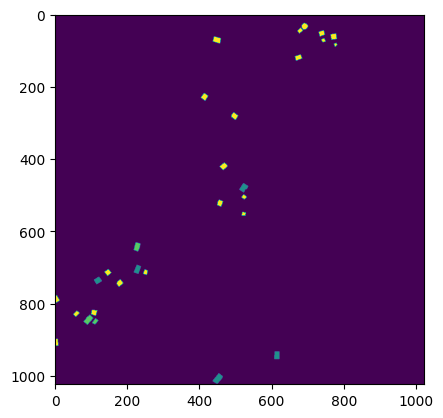

In [128]:
img = mpimg.imread('train/mask_polygon/hurricane-matthew_00000211_post_disaster.png')
imgplot = plt.imshow(img)
plt.show()

### Visualize data from targets folder

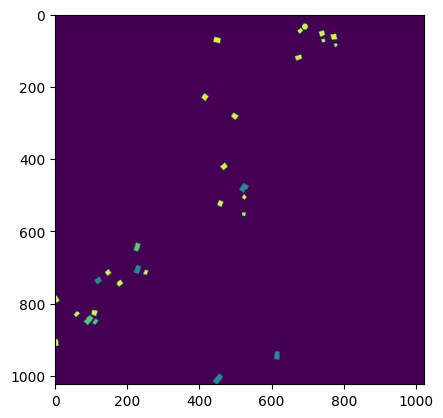

In [129]:
img = mpimg.imread('train/targets/hurricane-matthew_00000211_post_disaster_target.png')
imgplot = plt.imshow(img)
plt.show()

**Note**

**imread** function from different libraries has different behavior.
- imread function from *cv2*: when it read the image, the shape of data is in 3 dimensions
- imread function from *sklearn*: when it read the image, the shape of data is in 2 dimensions (Based on our understanding, it might happen because when we write the image data, we only specify height and width without specifying 3rd dimension.)

In [130]:
print(img.shape)

(1024, 1024)


In [131]:
image = imread('train/images/hurricane-matthew_00000211_post_disaster.png')

In [132]:
print(image.shape)

(1024, 1024, 3)


In [133]:
img.shape

(1024, 1024)

In [134]:
np.sum(img)

79.7451

In [135]:
output_path = 'test/mask_polygon'
labels_folder = 'test/labels'

damage_dict = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

for root, dirs, files in os.walk(labels_folder):
    for file in files:
        if ("hurricane-matthew" in file) and ("post" in file):
            polygons = json.load(open(os.path.join(root, file)))
            h = polygons["metadata"]["height"]
            w = polygons["metadata"]["width"]
            mask_img = np.zeros((h, w), np.uint8)
            for feature in polygons['features']['xy']:
                feature_poly = wkt.loads(feature['wkt'])
                coords = list(mapping(feature_poly)['coordinates'][0])
                fillPoly(mask_img, [np.array(coords, np.int32)], damage_dict[feature['properties']['subtype']])
            output_name = file.split('.')[0] + ".png"
            isExist = os.path.exists(output_path)
            if not isExist:
                os.makedirs(output_path)
            cv2.imwrite(os.path.join(output_path, output_name), mask_img)

## Prepare image patches

This part of code is modified from Classification of very high resolution satellite images using fully convolutional networks (Slum Segmentation Exercise) developed by Konstantin Maslov.

In [8]:
# define constants
BANDS_COUNT = 3

PATCH_SIZE = 128
BATCH_SIZE = 4

EPOCHS = 15
STEPS = 1000

def read_image(image_path):
    with rasterio.open(image_path) as image_file:
        height, width, depth = image_file.height, image_file.width, image_file.count
        image_arr = np.empty((height, width, depth))
        for band_idx in range(depth):
            band_arr = image_file.read(band_idx + 1)
            image_arr[:, :, band_idx] = band_arr
    return image_arr

def labels_to_onehot(labels_arr, classes_count):
    print(labels_arr.shape)
    height, width, _ = labels_arr.shape
    labels_arr = labels_arr[:, :, 0]
    labels_onehot = np.zeros((height, width, classes_count))
    for class_idx in range(classes_count):
        labels_onehot[:, :, class_idx][labels_arr == class_idx] = 1
    return labels_onehot

I modified TrainSequence and ValSequence function to make it be more dynamic.

Extra arguments
- process: localization (for building localization), classification (for damage classsification)
- classes_count: 2 (for localization task), 6 (for classification task)
- threshold: the number of images that we will use
- image_set: default is 'None' (for damage classification task), pre (for pre-disaster image), post (for post-disaster image)

In [9]:
class TrainSequence(kutils.Sequence):
    def __init__(self, folder_path, batch_size, patch_size, len, process, classes_count, threshold, image_set='None'):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.len = len
        self.process = process
        self.image_set = image_set
        self.classes_count = classes_count
        self.threshold = threshold
        self.read_dataset()
        self.reset()

    def read_dataset(self):
        # print('read dataset')
        self.data = []
        # self.len = 0
        pre_image_files = []
        post_image_files = []
        label_files = []
        count = 0

        # read RGB images
        for root, dirs, files in os.walk(self.folder_path+'/images'):
            # sort the files first to make sure that images are in same order and corresponding with their labels
            files.sort()
            for file in files:
                if ("hurricane-matthew" in file) and ("pre" in file):
                    image = imread(os.path.join(root, file))
                    pre_image_files.append(image)
                    count += 1
                elif ("hurricane-matthew" in file) and ("post" in file):
                    image = imread(os.path.join(root, file))
                    post_image_files.append(image)
                    count += 1
                # stop reading files if the threshold is reached
                if count == (self.threshold*2):
                    break
        count = 0

        # read labels (ground truth)
        if self.process == 'localization':
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                # sort the files first to make sure that labels are in same order and corresponding with their images
                files.sort()
                for file in files:
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            label = imread(os.path.join(root, file))
                            label = labels_to_onehot(label, self.classes_count)
                            label_files.append(label)
                            count += 1
                    # else:
                    #     if ("hurricane-matthew" in file) and ("post" in file):
                    #         print(file)
                    #         label = imread(os.path.join(root, file))
                    #         label = labels_to_onehot(label, self.classes_count)
                    #         label_files.append(label)
                    #         count += 1
                    # stop reading files if the threshold is reached
                    if count == len(pre_image_files):
                        break
        else:
            # building damage classification task
            # for root, dirs, files in os.walk(self.folder_path+'/mask_polygon'):
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                # sort the files first to make sure that labels are in same order and corresponding with their images
                files.sort()
                for file in files:
                    if ("hurricane-matthew" in file) and ("post" in file):
                        label = imread(os.path.join(root, file))
                        label = labels_to_onehot(label, self.classes_count)
                        label_files.append(label)
                        count += 1
                        if count == len(pre_image_files):
                            break

        # append the data to the list
        for i in range(len(label_files)):
            if self.process == 'localization':
                if self.image_set == 'pre':
                    self.data.append((pre_image_files[i], label_files[i]))
                # else:
                #     self.data.append((post_image_files[i], label_files[i]))
            else:
                stacked_images = np.concatenate((pre_image_files[i], post_image_files[i]), axis=2)
                print(stacked_images.shape)
                self.data.append((stacked_images, label_files[i]))


    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        success = False
        if self.process != 'localization':
            BANDS_COUNT = 6
        else:
            BANDS_COUNT = 3
        batch_x = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
        batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
        for patch_index in range(self.batch_size):
            while not success:
                image = self.sample_image()
                patch_image, patch_label = self.sample_patch(image)
                if np.sum(np.sum(patch_label, axis=0)[:, 0]) != 16384:
                    success = True
            batch_x[patch_index] = patch_image
            batch_y[patch_index] = patch_label
            success = False
        return batch_x, batch_y

    def sample_image(self):
        if self.image_index >= len(self.data):
            self.reset()
        image, label = self.data[self.image_index]
        return image, label

    def sample_patch(self, image_label_pair):
        image, label = image_label_pair
        height, width, _ = image.shape
        if self.x + self.patch_size > width:
            self.x = 0
            self.y += self.patch_size
        if self.y + self.patch_size > height:
            self.y = 0
            self.x = 0
            self.image_index += 1
            image, label = self.sample_image()
        
        patch_image = image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
        patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
        self.x += self.patch_size
        return patch_image, patch_label
        
    def reset(self):
        self.image_index = 0
        self.x = 0
        self.y = 0

For ValSequence class, we don't need to filter out the patches that has no building and we don't need to specify STEPS (len parameter).

In [10]:
class ValSequence(kutils.Sequence):
    def __init__(self, folder_path, batch_size, patch_size, process, classes_count, threshold, image_set='None'):
        self.folder_path = folder_path
        self.batch_size = batch_size
        self.patch_size = patch_size
        self.process = process
        self.image_set = image_set
        self.classes_count = classes_count
        self.threshold = threshold
        self.read_dataset()
        self.reset()

    def read_dataset(self):
        self.data = []
        self.len = 0
        pre_image_files = []
        post_image_files = []
        label_files = []
        count = 0
        for root, dirs, files in os.walk(self.folder_path+'/images'):
            # sort the files first to make sure that images are in same order and corresponding with their labels
            files.sort()
            for file in files:
                if ("hurricane-matthew" in file) and ("pre" in file):
                    image = imread(os.path.join(root, file))
                    pre_image_files.append(image)
                    count += 1
                elif ("hurricane-matthew" in file) and ("post" in file):
                    image = imread(os.path.join(root, file))
                    post_image_files.append(image)
                    count += 1
                # stop reading files if the threshold is reached
                if count == (self.threshold*2):
                    break

        count = 0
        if self.process == 'localization':
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                # sort the files first to make sure that labels are in same order and corresponding with their images
                files.sort()
                for file in files:
                    if self.image_set == 'pre':
                         if ("hurricane-matthew" in file) and ("pre" in file):
                            label = imread(os.path.join(root, file))
                            label = labels_to_onehot(label, self.classes_count)
                            label_files.append(label)
                            count += 1
                    # else:
                    #     if ("hurricane-matthew" in file) and ("post" in file):
                    #         label = imread(os.path.join(root, file))
                    #         label = labels_to_onehot(label, self.classes_count)
                    #         label_files.append(label)
                    #         count += 1
                    if count == len(pre_image_files):
                        break
        else:
            # for root, dirs, files in os.walk(self.folder_path+'/mask_polygon'):
            for root, dirs, files in os.walk(self.folder_path+'/targets'):
                # sort the files first to make sure that labels are in same order and corresponding with their images
                files.sort()
                for file in files:
                    if ("hurricane-matthew" in file) and ("post" in file):
                        label = imread(os.path.join(root, file))
                        label = labels_to_onehot(label, self.classes_count)
                        label_files.append(label)
                        count += 1
                        if count == len(pre_image_files):
                            break
        
        # append the data to the list
        for i in range(len(label_files)):
            if self.process == 'localization':
                if self.image_set == 'pre':
                    self.data.append((pre_image_files[i], label_files[i]))
                    height, width, _ = pre_image_files[i].shape
                # else:
                #     self.data.append((post_image_files[i], label_files[i]))
                #     height, width, _ = post_image_files[i].shape
                patches_count = (height // self.patch_size) * (width // self.patch_size)
                self.len += patches_count
            else:
                stacked_images = np.concatenate((pre_image_files[i], post_image_files[i]), axis=2)
                print(stacked_images.shape)
                self.data.append((stacked_images, label_files[i]))
                height, width, _ = stacked_images.shape
                patches_count = (height // self.patch_size) * (width // self.patch_size)
                self.len += patches_count

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        if self.process != 'localization':
            BANDS_COUNT = 6
        else:
            BANDS_COUNT = 3
        #if self.process == 'localization':
        batch_x = np.empty((self.batch_size, self.patch_size, self.patch_size, BANDS_COUNT))
        batch_y = np.empty((self.batch_size, self.patch_size, self.patch_size, self.classes_count))
        for patch_index in range(self.batch_size):
            image = self.sample_image()
            patch_image, patch_label = self.sample_patch(image)
            batch_x[patch_index] = patch_image
            batch_y[patch_index] = patch_label
        return batch_x, batch_y

    def sample_image(self):
        if self.image_index >= len(self.data):
            self.reset()
        image, label = self.data[self.image_index]
        return image, label

    def sample_patch(self, image_label_pair):
        image, label = image_label_pair
        height, width, _ = image.shape
        if self.x + self.patch_size > width:
            self.x = 0
            self.y += self.patch_size
        if self.y + self.patch_size > height:
            self.y = 0
            self.x = 0
            self.image_index += 1
            image, label = self.sample_image()
        
        patch_image = image[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
        patch_label = label[self.y:self.y + self.patch_size, self.x:self.x + self.patch_size, :]
        self.x += self.patch_size
        return patch_image, patch_label
        
    def reset(self):
        self.image_index = 0
        self.x = 0
        self.y = 0

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


[]

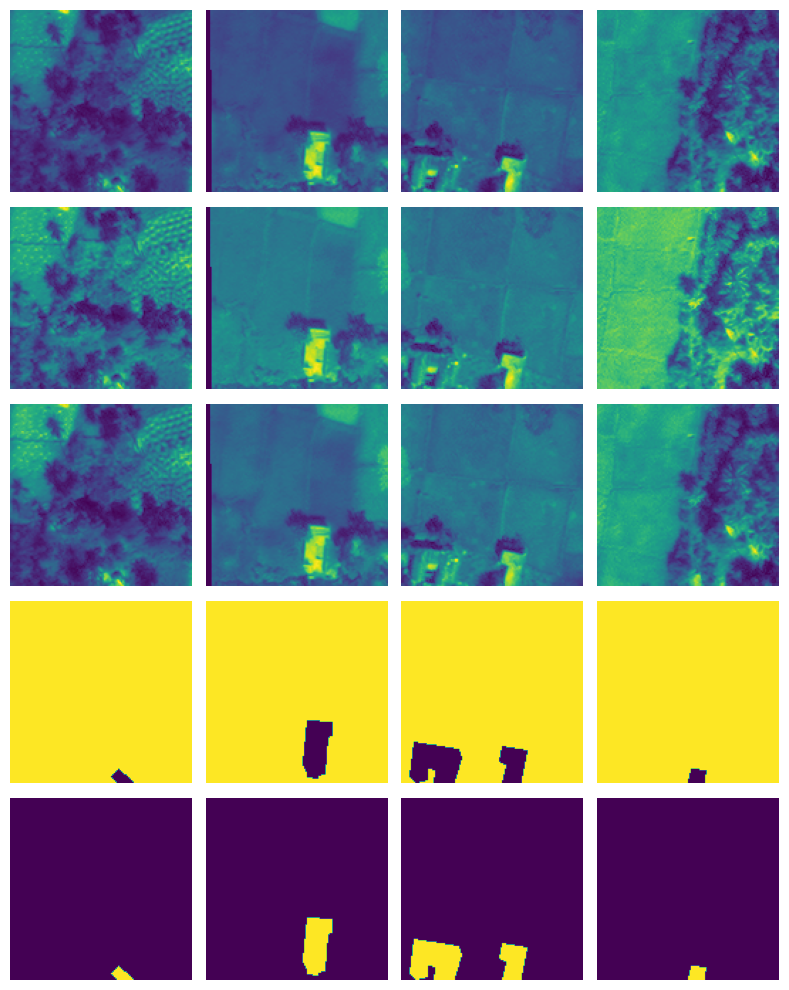

In [70]:
CLASSES_COUNT = 2
train_sequence = TrainSequence('train', BATCH_SIZE, PATCH_SIZE, STEPS, 'localization', CLASSES_COUNT, 40, 'pre')
# pre_img, post_img, y = train_sequence[0]
img, y = train_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

# for index, (x_item, y_item) in enumerate(zip(pre_img, y)):
for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)


[]

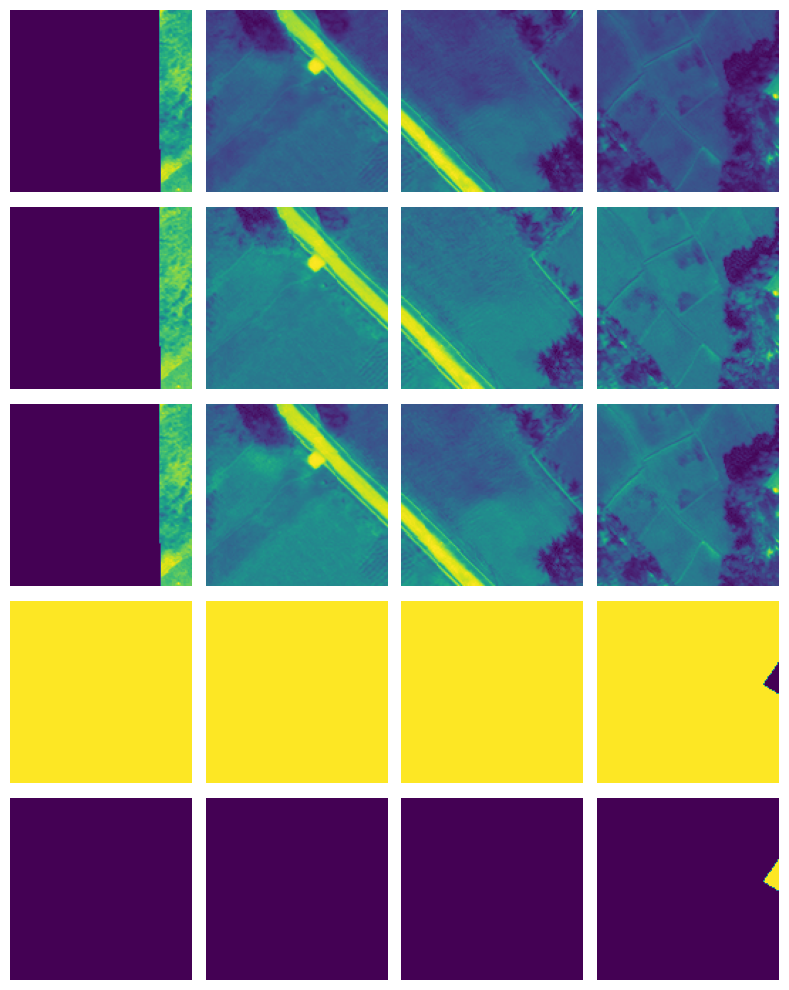

In [71]:
val_sequence = ValSequence('test', BATCH_SIZE, PATCH_SIZE, 'localization', CLASSES_COUNT, 4, 'pre')
img, y = val_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

# for index, (x_item, y_item) in enumerate(zip(pre_img, y)):
for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

In [72]:
len(train_sequence)

1000

In [73]:
len(val_sequence)

256

In [74]:
print(img.shape)
print(y.shape)

(4, 128, 128, 3)
(4, 128, 128, 2)


In [75]:
# print(pre_img.shape)
# print(post_img.shape)
# print(y.shape)

In [76]:
# Reset train and validation sequences
train_sequence.reset()
val_sequence.reset()

# Building localization

In [77]:
def apply_segmentation_with_fcn(image, fcn, patch_size=PATCH_SIZE, step=PATCH_SIZE//2):
    height, width, _ = image.shape
    # padded, (pad_height, pad_width) = pad_image_to_patch_size(image, patch_size)
    # height, width, _ = padded.shape
    
    predictions = np.zeros((height, width, CLASSES_COUNT))
    
    row = 0
    while row + patch_size <= height:
        row_patches = []

        col = 0 
        while col + patch_size <= width:
            patch = image[row:row + patch_size, col:col + patch_size, :]
            row_patches.append(patch)
            col += step

        batch = np.array(row_patches)
        row_predictions = fcn.predict(batch, verbose=0)

        col, patch_idx = 0, 0
        while col + patch_size <= width:
            predictions[row:row + patch_size, col:col + patch_size, :] += \
                row_predictions[patch_idx]
            col += step
            patch_idx += 1

        row += step

    # predictions = predictions[
    #     height,
    #     width, :
    # ]
    predictions = np.argmax(predictions, axis=-1)
    
    return predictions

## U-Net

In [78]:
model = dlmodels.unet((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_77 (Conv2D)             (None, 128, 128, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 128, 128, 32  128        ['conv2d_77[0][0]']              
 ormalization)                  )                                                           

In [79]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/15
1000/1000 [==============================] - 245s 244ms/step - loss: 0.1969 - accuracy: 0.9259 - val_loss: 0.1213 - val_accuracy: 0.9580
Epoch 2/15
1000/1000 [==============================] - 244s 244ms/step - loss: 0.1646 - accuracy: 0.9375 - val_loss: 0.0925 - val_accuracy: 0.9716
Epoch 3/15
1000/1000 [==============================] - 245s 245ms/step - loss: 0.1662 - accuracy: 0.9361 - val_loss: 0.0576 - val_accuracy: 0.9860
Epoch 4/15
1000/1000 [==============================] - 248s 248ms/step - loss: 0.1515 - accuracy: 0.9418 - val_loss: 0.0496 - val_accuracy: 0.9848
Epoch 5/15
1000/1000 [==============================] - 246s 246ms/step - loss: 0.1455 - accuracy: 0.9434 - val_loss: 0.0405 - val_accuracy: 0.9883
Epoch 6/15
1000/1000 [==============================] - 246s 246ms/step - loss: 0.1362 - accuracy: 0.9472 - val_loss: 0.0541 - val_accuracy: 0.9866
Epoch 7/15
1000/1000 [==============================] - 243s 243ms/step - loss: 0.1188 - accuracy: 0.9540 - val_

In [80]:
# save the weight of the trained network
model.save_weights("unet_weights_1_15epoch.h5")

In [81]:
len(val_sequence)

256

In [82]:
len(train_sequence)

1000

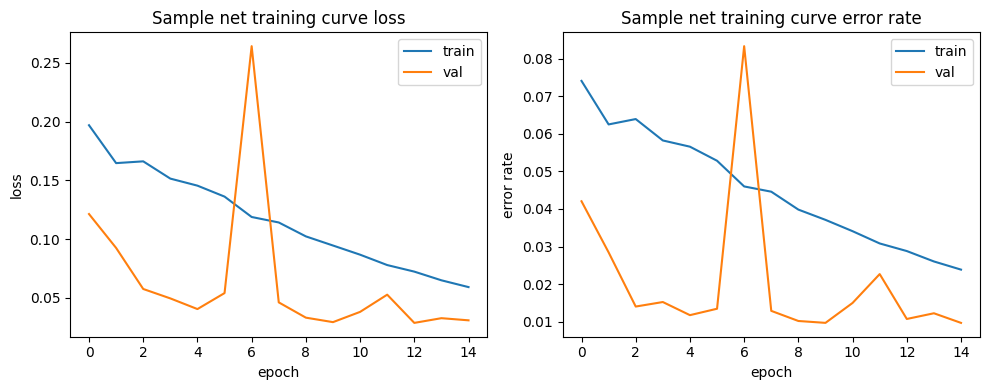

In [83]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [84]:
loss, accuracy = model.evaluate(val_sequence)
print(f"\nValidation accuracy of U-Net: {100 * accuracy:.2f}%")

256/256 [==============================] - 19s 76ms/step - loss: 0.0309 - accuracy: 0.9903

Validation accuracy of U-Net: 99.03%


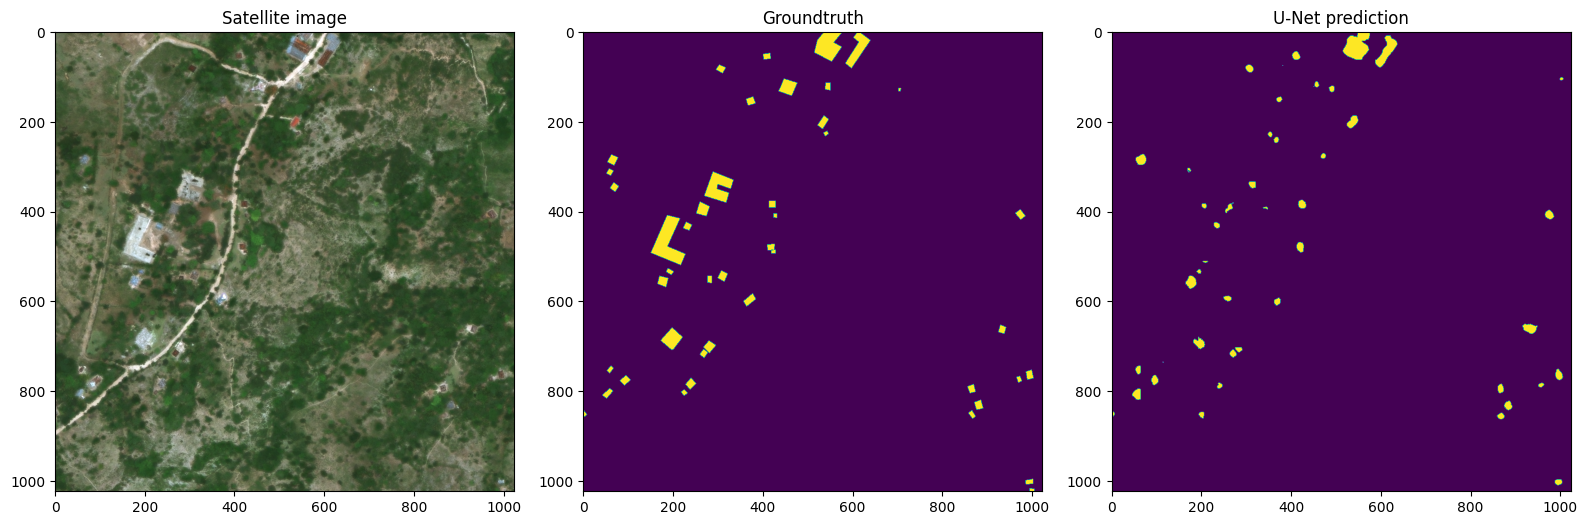

In [85]:
# let's classify one scene completely and see the results
image_path = 'test/images/hurricane-matthew_00000236_pre_disaster.png'
label_path = 'test/targets/hurricane-matthew_00000236_pre_disaster_target.png'

# image = read_image(image_path)
# label = read_image(label_path)
image = imread(image_path)
label = imread(label_path)

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("U-Net prediction")

plt.tight_layout()
plt.show()

## DK3

In [86]:
# reset the sequences
train_sequence.reset()
val_sequence.reset()

In [87]:
model = dlmodels.dk3((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_12 (ZeroPadd  (None, 132, 132, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_100 (Conv2D)         (None, 128, 128, 16)      1216      
                                                                 
 batch_normalization_94 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_94 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 132, 132, 16)     0         
 ing2D)                                                          
                                                      

In [88]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/15
1000/1000 [==============================] - 49s 49ms/step - loss: 0.2053 - accuracy: 0.9224 - val_loss: 0.0576 - val_accuracy: 0.9844
Epoch 2/15
1000/1000 [==============================] - 49s 49ms/step - loss: 0.1565 - accuracy: 0.9408 - val_loss: 0.0396 - val_accuracy: 0.9861
Epoch 3/15
1000/1000 [==============================] - 49s 49ms/step - loss: 0.1507 - accuracy: 0.9430 - val_loss: 0.0399 - val_accuracy: 0.9887
Epoch 4/15
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1373 - accuracy: 0.9474 - val_loss: 0.0392 - val_accuracy: 0.9878
Epoch 5/15
1000/1000 [==============================] - 49s 49ms/step - loss: 0.1317 - accuracy: 0.9492 - val_loss: 0.0651 - val_accuracy: 0.9834
Epoch 6/15
1000/1000 [==============================] - 50s 50ms/step - loss: 0.1289 - accuracy: 0.9503 - val_loss: 0.0800 - val_accuracy: 0.9856
Epoch 7/15
1000/1000 [==============================] - 49s 49ms/step - loss: 0.1197 - accuracy: 0.9537 - val_loss: 0.1043 -

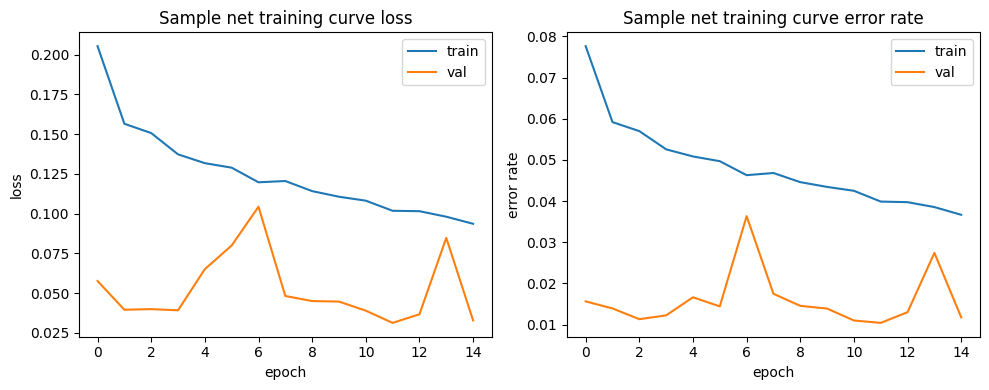

In [89]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [90]:
loss, accuracy = model.evaluate(val_sequence)
print(f"\nValidation accuracy of DK3: {100 * accuracy:.2f}%")

256/256 [==============================] - 4s 16ms/step - loss: 0.0328 - accuracy: 0.9882

Validation accuracy of DK3: 98.82%


In [91]:
# save the weight of the trained network
model.save_weights("dk3_weights_15epoch.h5")

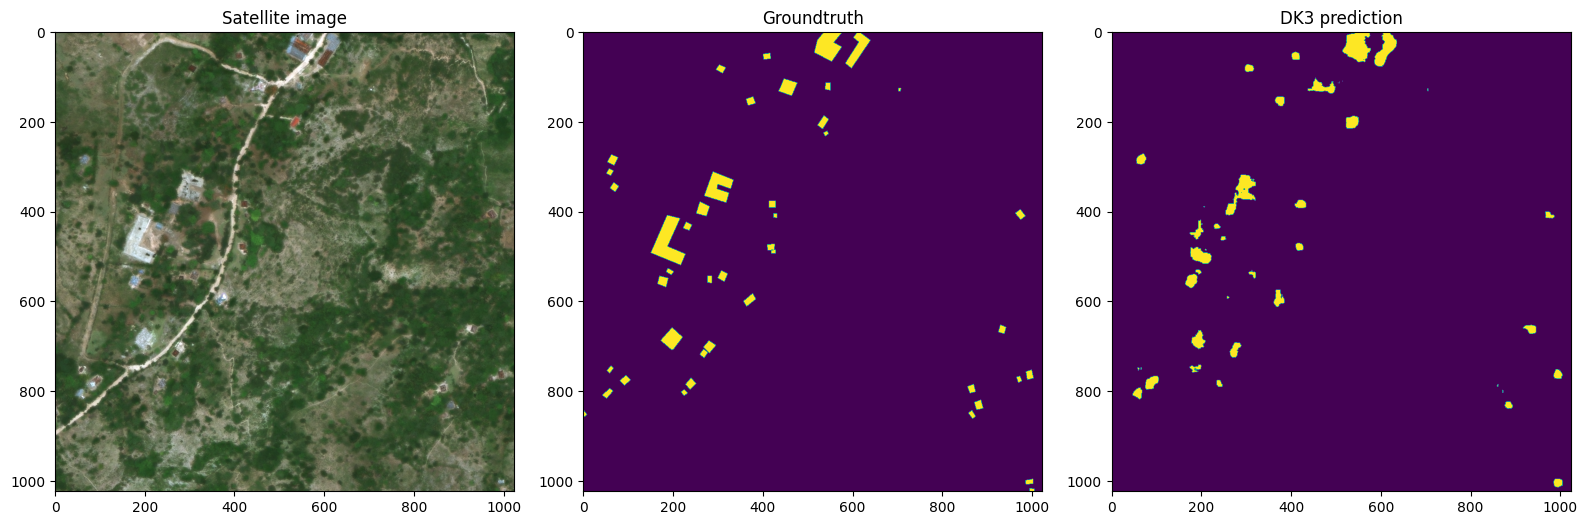

In [92]:
# let's classify one scene completely and see the results
# image_path = 'test/images/hurricane-matthew_00000397_pre_disaster.png'
# label_path = 'test/targets/hurricane-matthew_00000397_pre_disaster_target.png'
image_path = 'test/images/hurricane-matthew_00000236_pre_disaster.png'
label_path = 'test/targets/hurricane-matthew_00000236_pre_disaster_target.png'

# image = read_image(image_path)
# label = read_image(label_path)
image = imread(image_path)
label = imread(label_path)

prediction = apply_segmentation_with_fcn(image, model)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Satellite image")
axs[1].imshow(label[:, :, 0])
axs[1].set_title("Groundtruth")
axs[2].imshow(prediction)
axs[2].set_title("DK3 prediction")

plt.tight_layout()
plt.show()

## DK6

In [ ]:
model = dlmodels.dk6((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model.summary()

## Post disaster images

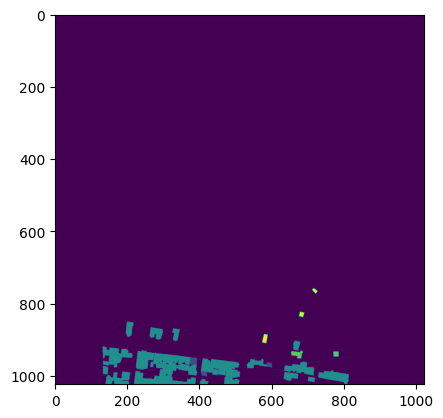

In [42]:
img = imread('train/targets/hurricane-matthew_00000000_post_disaster_target.png')
imgplot = plt.imshow(img[:, :, 0])
plt.show()

In [43]:
np.unique(img)

array([0, 1, 2, 3, 4], dtype=uint8)

In [45]:
img[:,:,0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

# Load pre-trained model

In [37]:
# model.load_weights(os.path.join('unet_weights_1.h5'))


In [ ]:
# model.compile(
#     loss="categorical_crossentropy",
#     optimizer=optimizers.Adam(learning_rate=1e-3),
#     metrics=["accuracy"]
# )

# loss, accuracy = model.evaluate(val_sequence)
# print(f"\nValidation accuracy of U-Net: {100 * accuracy:.2f}%")

# Building damage classification

### Remarks!

There is some **inconsistens** between mask polygon output and provided ground truth raster from targets folder

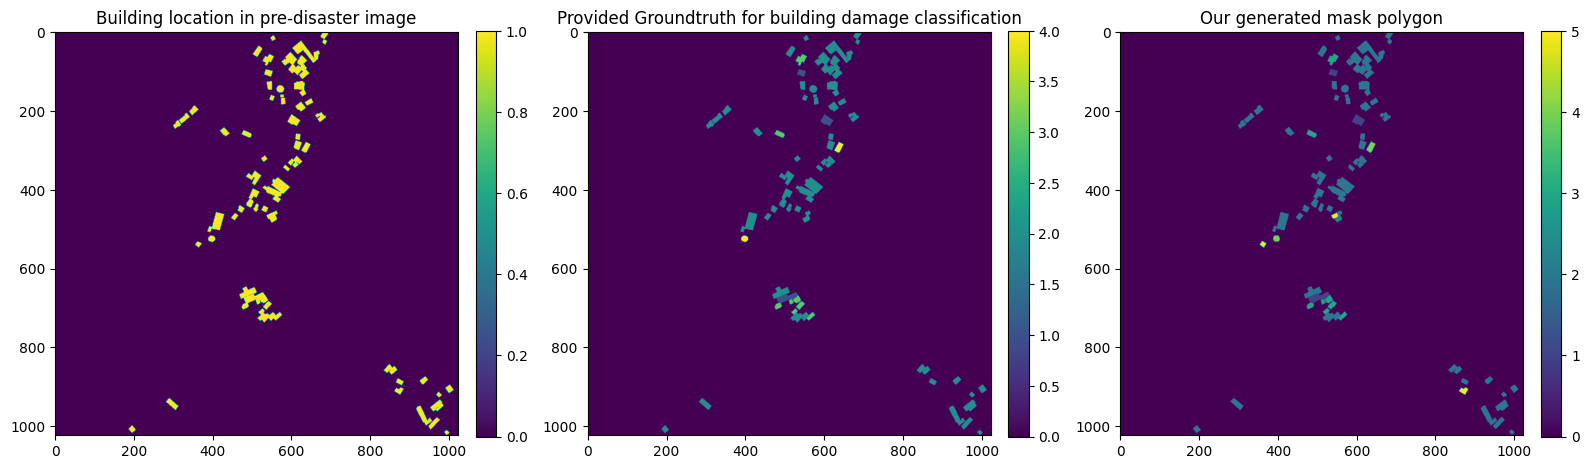

In [113]:
pre_target_image_path = 'test/targets/hurricane-matthew_00000010_pre_disaster_target.png'
post_target_image_path = 'test/targets/hurricane-matthew_00000010_post_disaster_target.png'
mask_polygon_image_path = 'test/mask_polygon/hurricane-matthew_00000010_post_disaster.png'

# image = read_image(image_path)
# label = read_image(label_path)
pre_target_image = imread(pre_target_image_path)
post_target_image = imread(post_target_image_path)
mask_polygon_image = imread(mask_polygon_image_path)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))

im1 = axs[0].imshow(pre_target_image[:, :, 0])
axs[0].set_title("Building location in pre-disaster image")
im2 = axs[1].imshow(post_target_image[:, :, 0])
axs[1].set_title("Provided Groundtruth for building damage classification")
im3 = axs[2].imshow(mask_polygon_image[:, :, 0])
axs[2].set_title("Our generated mask polygon")

fig.colorbar(im1, fraction=0.046, pad=0.04)
fig.colorbar(im2, fraction=0.046, pad=0.04)
fig.colorbar(im3, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [95]:
print(np.unique(pre_target_image))
print(np.unique(post_target_image))
print(np.unique(mask_polygon_image))

[0 1]
[0 1 2 3 4]
[0 1 2 3 4 5]


In [122]:
# set new values for constants for trial
EPOCHS = 10
STEPS = 700

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)
(1024, 1024, 6)


[]

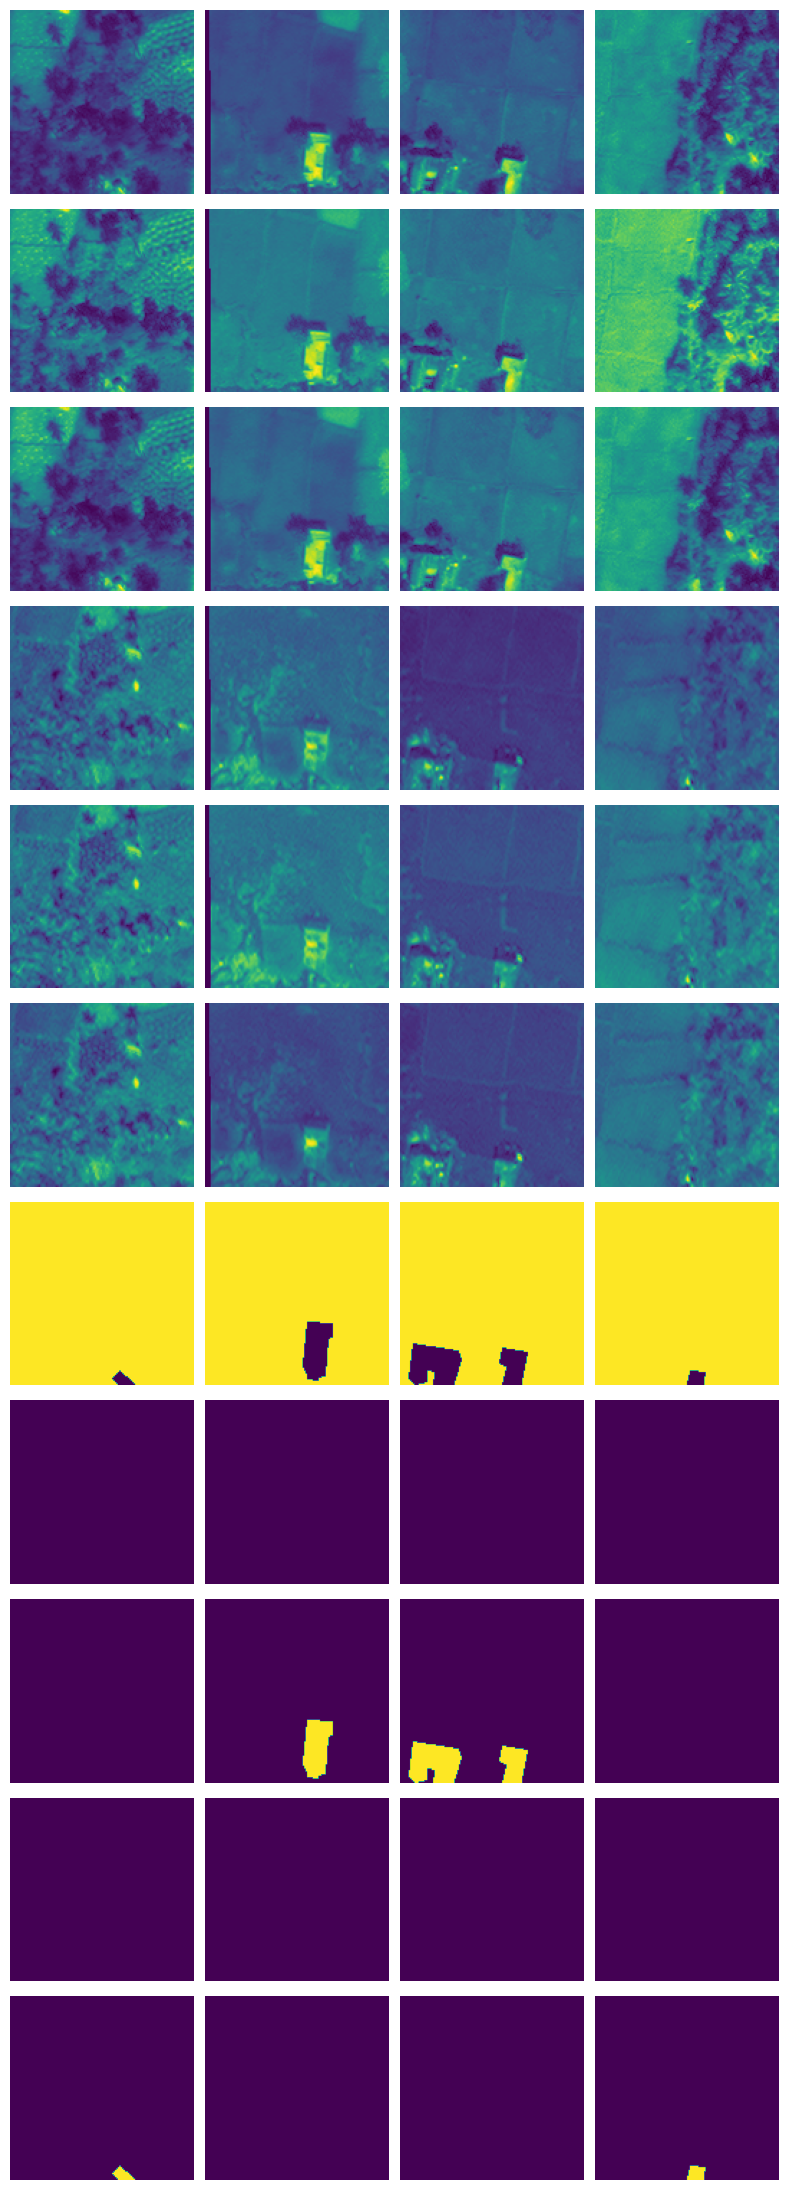

In [136]:
CLASSES_COUNT = 5
BANDS_COUNT = 6
# threshold is set to 20 to read only 20 pre- and post-disaster images
train_sequence = TrainSequence('train', BATCH_SIZE, PATCH_SIZE, STEPS, 'classification', CLASSES_COUNT, 20)
img, y = train_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

# for index, (pre_img_item, post_img_item, y_item) in enumerate(zip(pre_img, post_img, y)):
for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

(1024, 1024, 3)
(1024, 1024, 3)
(1024, 1024, 6)
(1024, 1024, 6)


[]

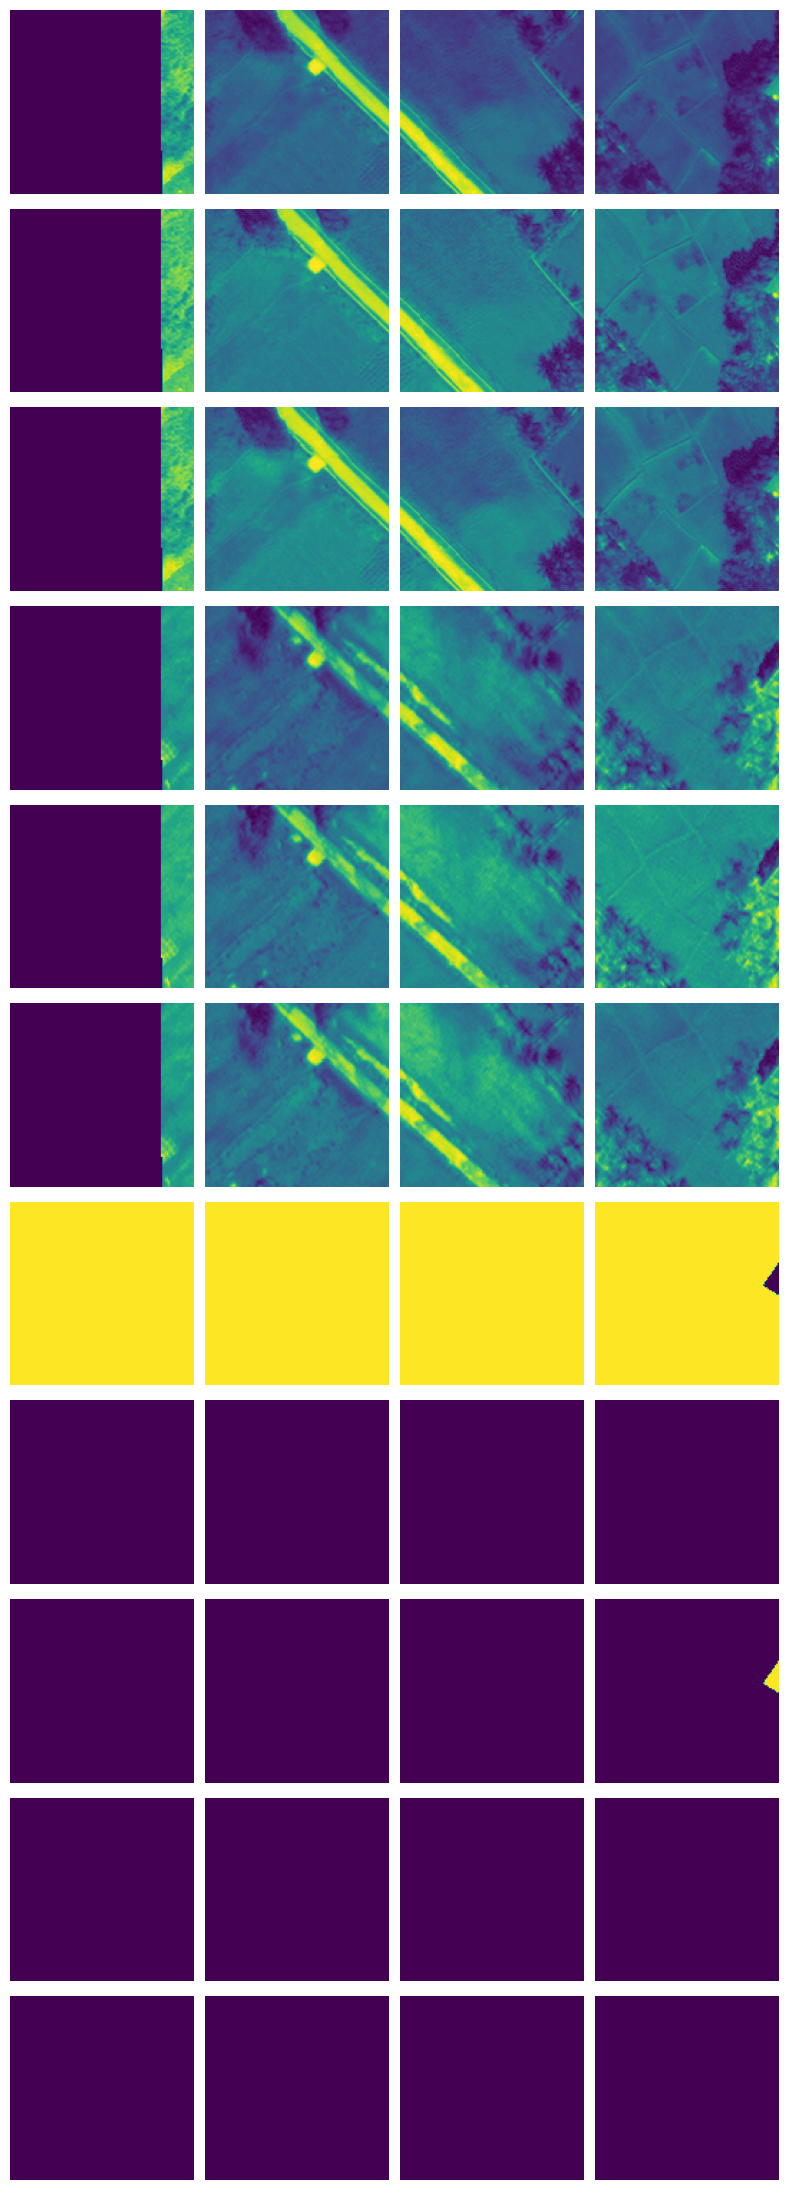

In [137]:
val_sequence = ValSequence('test', BATCH_SIZE, PATCH_SIZE, 'classification', CLASSES_COUNT, 2)
img, y = val_sequence[0]
nrows, ncols = BANDS_COUNT + CLASSES_COUNT, BATCH_SIZE
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows))

for index, (x_item, y_item) in enumerate(zip(img, y)):
# for index, (x_item, y_item) in enumerate(zip(img, y)):
    for row in range(BANDS_COUNT):
        axes[row][index].imshow(x_item[:, :, row])
        axes[row][index].axis("off")
    for class_index in range(CLASSES_COUNT):
        row = BANDS_COUNT + class_index
        axes[row][index].imshow(y_item[:, :, class_index], vmin=0, vmax=1)
        axes[row][index].axis("off")

plt.tight_layout()
plt.plot()

In [138]:
print(len(train_sequence))
print(len(val_sequence))

700
128


In [139]:
# reset the sequences
train_sequence.reset()
val_sequence.reset()

## U-Net

In [140]:
model_all = dlmodels.unet((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model_all.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_127 (Conv2D)            (None, 128, 128, 32  1760        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_119 (Batch  (None, 128, 128, 32  128        ['conv2d_127[0][0]']             
 Normalization)                 )                                                           

In [141]:
model_all.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model_all.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/10
700/700 [==============================] - 163s 231ms/step - loss: 0.2858 - accuracy: 0.9283 - val_loss: 0.2519 - val_accuracy: 0.9239
Epoch 2/10
700/700 [==============================] - 165s 236ms/step - loss: 0.2352 - accuracy: 0.9287 - val_loss: 0.1448 - val_accuracy: 0.9700
Epoch 3/10
700/700 [==============================] - 167s 238ms/step - loss: 0.2172 - accuracy: 0.9321 - val_loss: 0.1981 - val_accuracy: 0.9237
Epoch 4/10
700/700 [==============================] - 167s 238ms/step - loss: 0.2123 - accuracy: 0.9320 - val_loss: 0.5692 - val_accuracy: 0.8153
Epoch 5/10
700/700 [==============================] - 168s 240ms/step - loss: 0.1968 - accuracy: 0.9350 - val_loss: 0.1006 - val_accuracy: 0.9725
Epoch 6/10
700/700 [==============================] - 168s 240ms/step - loss: 0.1914 - accuracy: 0.9361 - val_loss: 0.1250 - val_accuracy: 0.9569
Epoch 7/10
700/700 [==============================] - 168s 240ms/step - loss: 0.1790 - accuracy: 0.9389 - val_loss: 0.0985 -

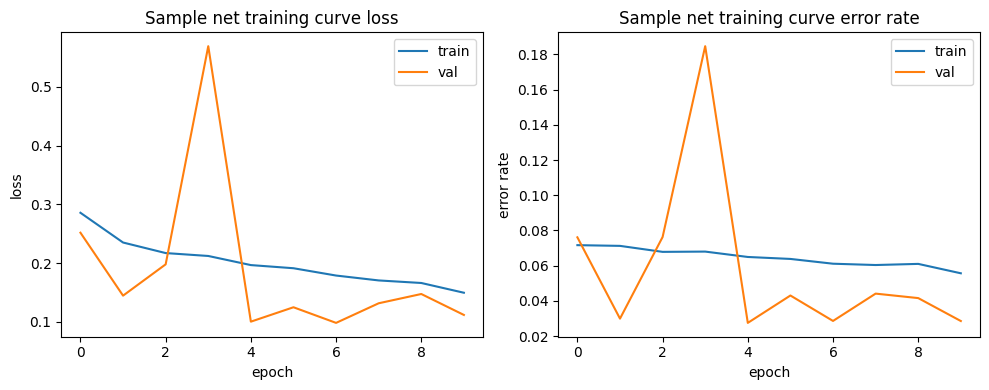

In [142]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [143]:
loss, accuracy = model_all.evaluate(val_sequence)
print(f"\nValidation accuracy of U-net: {100 * accuracy:.2f}%")

128/128 [==============================] - 10s 78ms/step - loss: 0.1120 - accuracy: 0.9714

Validation accuracy of U-net: 97.14%


In [147]:
# save the weight of the trained network
model_all.save_weights("unet_weights_damage_1.h5")

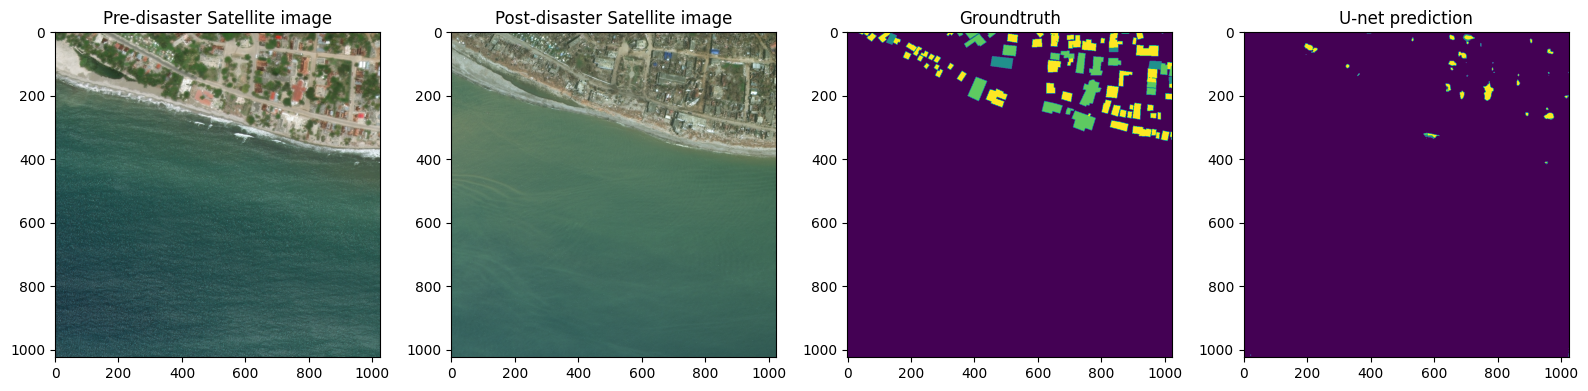

In [146]:
# let's classify one scene completely and see the results
image_pre_path = 'test/images/hurricane-matthew_00000395_pre_disaster.png'
image_post_path = 'test/images/hurricane-matthew_00000395_post_disaster.png'
label_path = 'test/targets/hurricane-matthew_00000395_post_disaster_target.png'

# image = read_image(image_path)
# label = read_image(label_path)
pre_image = imread(image_pre_path)
post_image = imread(image_post_path)
label = imread(label_path)

image = np.concatenate((pre_image, post_image), axis=2)

prediction = apply_segmentation_with_fcn(image, model_all)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Pre-disaster Satellite image")
axs[1].imshow(image[:, :, [5, 4, 3]])
axs[1].set_title("Post-disaster Satellite image")
axs[2].imshow(label[:, :, 0])
axs[2].set_title("Groundtruth")
axs[3].imshow(prediction)
axs[3].set_title("U-net prediction")

plt.tight_layout()
plt.show()

## DK3

In [148]:
print(CLASSES_COUNT)

5


In [155]:
# reset the sequences
train_sequence.reset()
val_sequence.reset()

In [156]:
model_all = dlmodels.dk3((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model_all.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_24 (ZeroPadd  (None, 132, 132, 6)      0         
 ing2D)                                                          
                                                                 
 conv2d_154 (Conv2D)         (None, 128, 128, 16)      2416      
                                                                 
 batch_normalization_144 (Ba  (None, 128, 128, 16)     64        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_144 (LeakyReLU)  (None, 128, 128, 16)     0         
                                                                 
 zero_padding2d_25 (ZeroPadd  (None, 132, 132, 16)     0         
 ing2D)                                                          
                                                      

In [157]:
model_all.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model_all.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/10
700/700 [==============================] - 36s 50ms/step - loss: 0.3529 - accuracy: 0.8975 - val_loss: 0.3303 - val_accuracy: 0.9346
Epoch 2/10
700/700 [==============================] - 35s 50ms/step - loss: 0.2255 - accuracy: 0.9308 - val_loss: 0.1295 - val_accuracy: 0.9678
Epoch 3/10
700/700 [==============================] - 35s 50ms/step - loss: 0.2006 - accuracy: 0.9357 - val_loss: 0.1405 - val_accuracy: 0.9706
Epoch 4/10
700/700 [==============================] - 35s 50ms/step - loss: 0.1917 - accuracy: 0.9370 - val_loss: 0.6702 - val_accuracy: 0.7153
Epoch 5/10
700/700 [==============================] - 34s 49ms/step - loss: 0.1758 - accuracy: 0.9418 - val_loss: 0.1635 - val_accuracy: 0.9708
Epoch 6/10
700/700 [==============================] - 34s 49ms/step - loss: 0.1677 - accuracy: 0.9441 - val_loss: 0.1392 - val_accuracy: 0.9644
Epoch 7/10
700/700 [==============================] - 33s 47ms/step - loss: 0.1567 - accuracy: 0.9476 - val_loss: 0.1235 - val_accuracy:

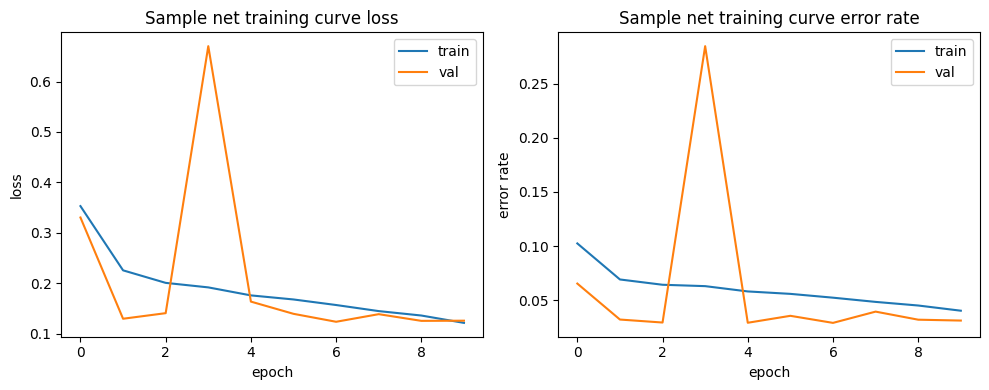

In [162]:
# plot model training history
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axs[0].set_title("Sample net training curve loss")
axs[0].plot(history.history["loss"], label="train")
axs[0].plot(history.history["val_loss"], label="val")
axs[0].legend()
axs[0].set_ylabel("loss")
axs[0].set_xlabel("epoch")

axs[1].set_title("Sample net training curve error rate")
axs[1].plot([1 - _ for _ in history.history["accuracy"]], label="train")
axs[1].plot([1 - _ for _ in history.history["val_accuracy"]], label="val")
axs[1].legend()
axs[1].set_ylabel("error rate")
axs[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [163]:
loss, accuracy = model_all.evaluate(val_sequence)
print(f"\nValidation accuracy of DK3: {100 * accuracy:.2f}%")

128/128 [==============================] - 2s 15ms/step - loss: 0.1256 - accuracy: 0.9687

Validation accuracy of DK3: 96.87%


In [164]:
# save the weight of the trained network
model_all.save_weights("dk3_weights_damage_1.h5")

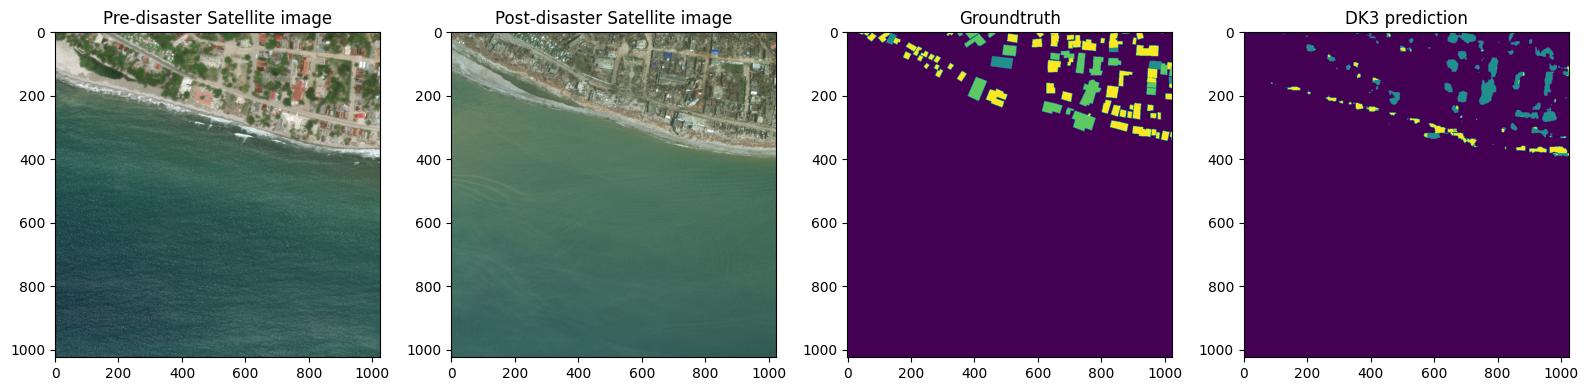

In [165]:
# let's classify one scene completely and see the results
image_pre_path = 'test/images/hurricane-matthew_00000395_pre_disaster.png'
image_post_path = 'test/images/hurricane-matthew_00000395_post_disaster.png'
label_path = 'test/targets/hurricane-matthew_00000395_post_disaster_target.png'

# image = read_image(image_path)
# label = read_image(label_path)
pre_image = imread(image_pre_path)
post_image = imread(image_post_path)
label = imread(label_path)

image = np.concatenate((pre_image, post_image), axis=2)

prediction = apply_segmentation_with_fcn(image, model_all)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 7))

axs[0].imshow(image[:, :, [2, 1, 0]])
axs[0].set_title("Pre-disaster Satellite image")
axs[1].imshow(image[:, :, [5, 4, 3]])
axs[1].set_title("Post-disaster Satellite image")
axs[2].imshow(label[:, :, 0])
axs[2].set_title("Groundtruth")
axs[3].imshow(prediction)
axs[3].set_title("DK3 prediction")

plt.tight_layout()
plt.show()

In [ ]:
CLASSES_COUNT = 5
EPOCHS = 10
STEPS = 700

In [11]:
model = dlmodels.segnet((PATCH_SIZE, PATCH_SIZE, BANDS_COUNT), CLASSES_COUNT)
model.summary()

NameError: name 'CLASSES_COUNT' is not defined

In [168]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

history = model.fit(
    train_sequence, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_sequence
)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\japan\AppData\Local\Temp\ipykernel_23352\3295524790.py", line 7, in <module>
      history = model.fit(
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\Users\japan\anaconda3\envs\aia\envs\tf\lib\site-packages\keras\backend.py", line 5535, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[65536,2] labels_size=[65536,5]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_531221]